# Hands-on: Classification of Liver With or Without Tumor on CT Images
2022 Summer 最後修改日期：2022/07/13
## CNN Classification
Dataset reference: [Medical Segmentation Decathlon](http://medicaldecathlon.com/) \
[Slido](https://www.slido.com/) Code: 1087490

## 0\. 準備工作
* 請先至左上角的「檔案」內點選「在雲端硬碟中儲存複本」。
* 點選下列連結之一：
    * [Link_0](https://drive.google.com/file/d/1-W8OwU4rjjsC3QkNprCDBrVhmlNoorVF/view?usp=sharing)
    * [Link_1](https://drive.google.com/file/d/1l6hz-VyXB0j5m0egBQJVbGehfVIAxRSc/view?usp=sharing)
    * [Link_2](https://drive.google.com/file/d/1xNLLjlNcaJZXVlQMHgxgHA6rUn21bhUK/view?usp=sharing)
* 在右上角「新增雲端硬碟捷徑」到「我的雲端硬碟」。\
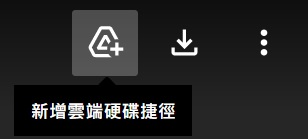 \
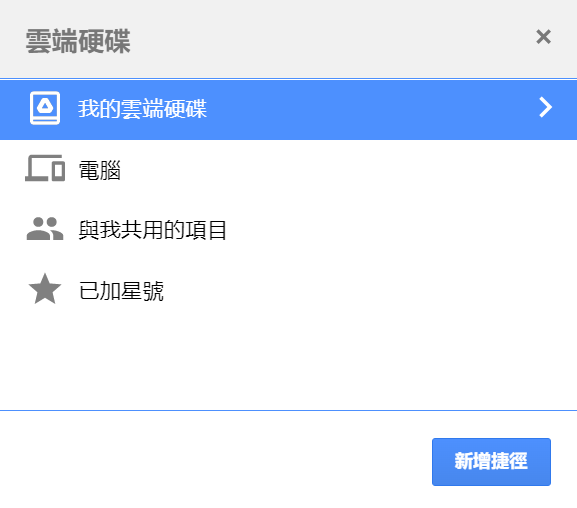
* 請在**自己**的Notebook中的「執行階段」內點選「變更執行階段類型」，並將硬體加速器改為「GPU」。
* 執行以下程式，將雲端硬碟掛載到Colab上。

In [5]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


# **補充說明**
``` python
# 一行一行讀

# 字串
"string"
'string'
f"{new_variable}"

# Assignment
new_variable = "ddddd"

# Conditional
if 5 > 3:
  print("正確答案")
else:
  print("錯誤答案")

# For Loop
for 蘋果 in 籃子:
  拿起來看

# a Python function is something like
def say_hello(name):
  print(f"hi {name}")
  return 0
  
# a Python list is something like
list_1 = ['a', 'b', 'c']
list_2 = [0, 1, 2]
# we get item in a list with index
print(list_1[0])
# output: a

# a Python dictionary is something like
dict_1 = {'a': 0, 'b': 1, 'c': 2}
# we get value in a dictionary with key
print(dict_1['a'])
# output: 0
```

## 1\. 設置執行環境

In [2]:
!pip install monai timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.4 MB/s eta 0:00:00


In [3]:
import os
import shutil
from tqdm.notebook import tqdm
import yaml

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import timm
import torch

import monai
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, EnsureTyped, LoadImaged,
    MaskIntensityd, RandAffined, RandFlipd,
    RepeatChanneld, Resized, ScaleIntensityd,
    ScaleIntensityRanged, ToDeviced
)
from monai.utils.misc import set_determinism

set_determinism(42)

## 2\. 移動資料，解壓縮

In [6]:
data_zip = 'liver_data.zip'
data_dir = '/content/liver_data'
# move the data to current directory
if os.path.exists(f'/content/drive/MyDrive/{data_zip}'):
  shutil.copyfile(f'/content/drive/MyDrive/{data_zip}', f'/content/{data_zip}')

# unzip the file
if os.path.exists(f'/content/{data_zip}') and not os.path.exists(data_dir):
    print('Unzipping...')
    cmd = f'unzip {data_zip}'
    ret_code = os.system(cmd)
    print(f'{cmd} completed with return code {ret_code}')

if not os.path.exists(data_dir):
    print("Data directory doesn't exist.")
else:
    print("Data successfully downloaded and unzipped")

Unzipping...
unzip liver_data.zip completed with return code 0
Data successfully downloaded and unzipped


## 3\. 載入並檢視資料


### 3-1. 檢查資料，視覺化資料
檢查資料量

In [5]:
# set the path
images_dir = os.path.join(data_dir, 'images')
masks_dir = os.path.join(data_dir, 'masks')

# check how much data we have
print('Number of images:', len(os.listdir(images_dir)))
print('Number of masks:', len(os.listdir(masks_dir)))

Number of images: 3713
Number of masks: 3713


In [6]:
data_list = yaml.safe_load(open('/content/liver_data/data_list.yaml', 'r'))
train_list = data_list['train']
valid_list = data_list['valid']
test_list = data_list['test']

print(f'{len(train_list)} data for training')
print(f'{len(valid_list)} data for validation')
print(f'{len(test_list)} data for testing')

2241 data for training: [{'image': '/content/liver_data/images/liver_103_20.nii.gz', 'label': [0.0], 'mask': '/content/liver_data/masks/liver_103_20.nii.gz'}, {'image': '/content/liver_data/images/liver_103_13.nii.gz', 'label': [1.0], 'mask': '/content/liver_data/masks/liver_103_13.nii.gz'}]
720 data for validation: [{'image': '/content/liver_data/images/liver_115_2.nii.gz', 'label': [0.0], 'mask': '/content/liver_data/masks/liver_115_2.nii.gz'}, {'image': '/content/liver_data/images/liver_115_14.nii.gz', 'label': [0.0], 'mask': '/content/liver_data/masks/liver_115_14.nii.gz'}]
752 data for testing: [{'image': '/content/liver_data/images/liver_90_20.nii.gz', 'label': [1.0], 'mask': '/content/liver_data/masks/liver_90_20.nii.gz'}, {'image': '/content/liver_data/images/liver_90_11.nii.gz', 'label': [1.0], 'mask': '/content/liver_data/masks/liver_90_11.nii.gz'}]


In [53]:
# helper function for plotting image
def show_data(data, with_mask=False, to_cpu=True):

    column_cnt = 2 if with_mask else 1
    image = data['image'][0]
    mask = data['mask'][0]

    if to_cpu:
        image = image.cpu()
        mask = mask.cpu()

    fig, axs = plt.subplots(1, column_cnt, figsize=(5*column_cnt, 4))
    image_title = f"Label: {data['label'].item()}"

    if with_mask:
        axs[0].imshow(image, cmap='gray')
        axs[0].set_title(image_title)

        label_title = "Corresponding Mask"
        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title(label_title)

    else:
        axs.imshow(image, cmap='gray')
        axs.set_title(image_title)

    plt.show()

def show_transform_result(data, trans_data, with_mask=False, with_histogram=False):

    assert not (with_mask and with_histogram), "Cannot plot both histogram and mask"

    if with_mask or with_histogram:
        column_cnt = 4
        axis_for_trans_data = 2
    else:
        column_cnt = 2
        axis_for_trans_data = 1

    fig, axs = plt.subplots(1, column_cnt, figsize=(5*column_cnt, 4))

    axs[0].imshow(data['image'][0], cmap='gray')
    axs[0].set_title("Original Data")

    axs[axis_for_trans_data].imshow(trans_data['image'][0], cmap='gray')
    axs[axis_for_trans_data].set_title("Transformed Data")

    if with_mask:
        axs[1].imshow(data['mask'][0], cmap='gray')
        axs[1].set_title("Original Mask")
        axs[3].imshow(trans_data['mask'][0], cmap='gray')
        axs[3].set_title("Transformed Mask")

    if with_histogram:
        ori_counts, ori_bins = np.histogram(data['image'][0], bins=256)
        axs[1].hist(ori_bins[:-1], bins=256, weights=ori_counts, log=True)
        trans_counts, trans_bins = np.histogram(trans_data['image'][0], bins=256)
        axs[3].hist(trans_bins[:-1], bins=256, weights=trans_counts, log=True)

    plt.show()


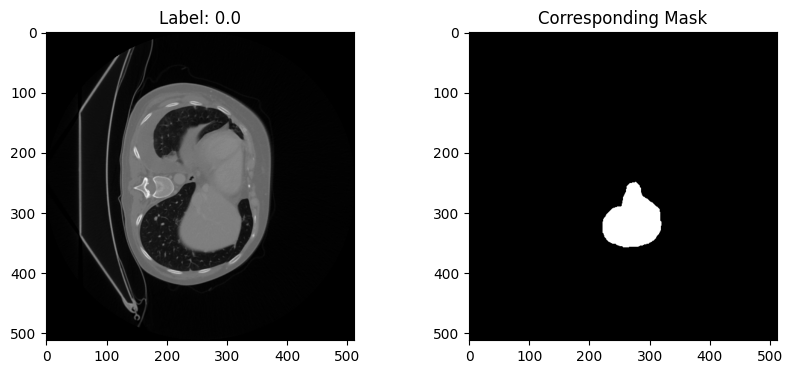

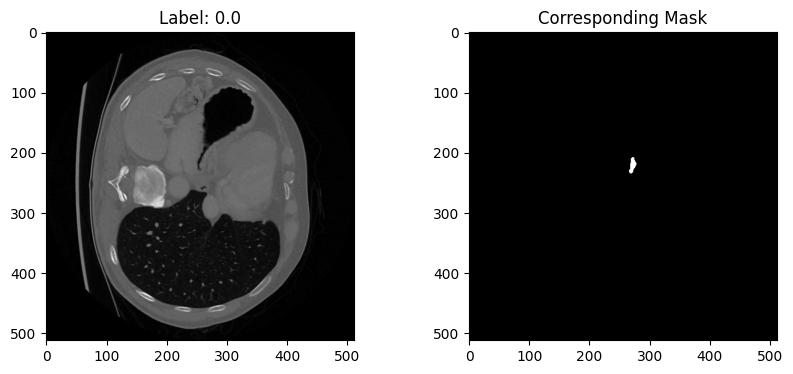

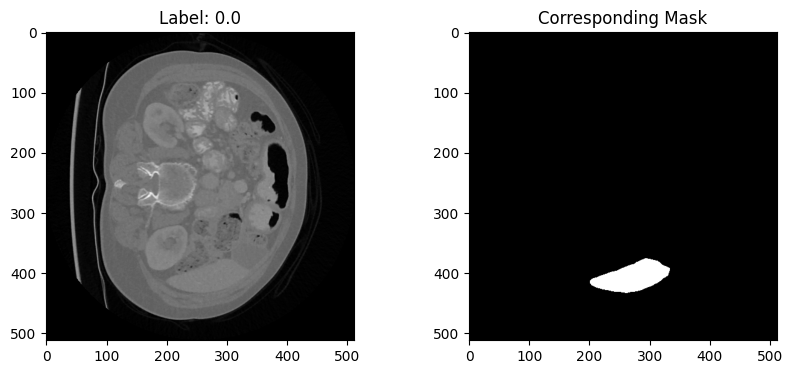

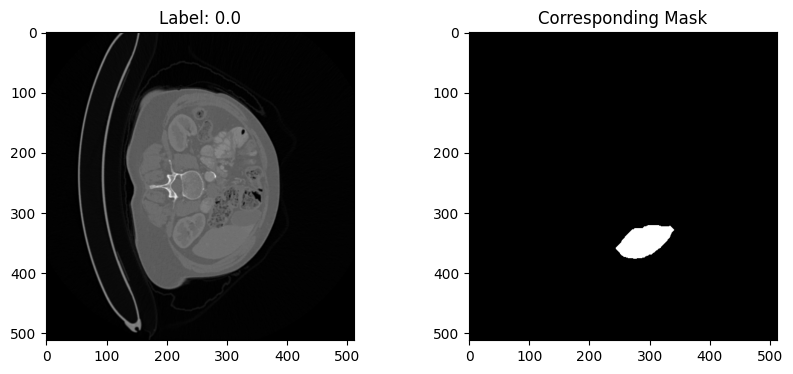

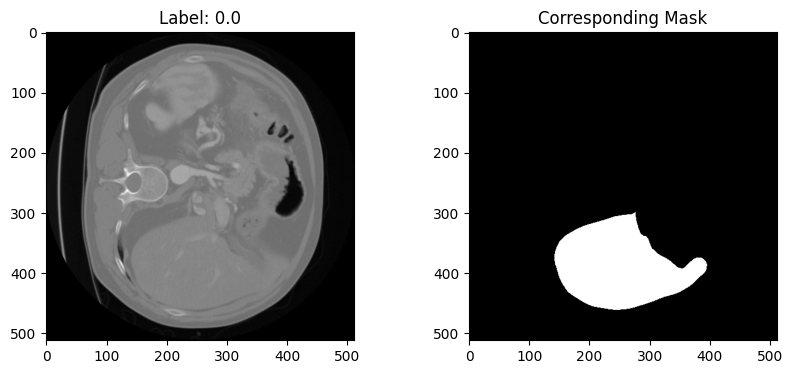

In [54]:
############### change here #################
# number of data to be visualized
num = 5
############### change here #################

load = Compose([
    LoadImaged(keys=['image', 'mask'], ensure_channel_first=True),
    EnsureTyped(keys=["label"])
])

random_index = np.random.randint(0, len(train_list), num)
for index in random_index:

    data = train_list[int(index)]
    data = load(data)

    show_data(data, with_mask=True)

### 3-2. 資料前處理說明
我們需要載入資料並進行前處理

1.   把資料整理成模型需要的格式





2.   去除沒有用的雜訊


以下是會使用到的前處理步驟：

*   **調整大小**：調整圖像到特定大小。這裡示範的模型接受的影像大小是 (224, 224) (可在載入權重時注意到)，所以需要將影像調整成 (224, 224)。
*   **開窗**：調整影像的亮度和對比。這前處理只適合CT。可調整窗寬和窗位。
*   **資料正規化**：將每一個像素的值調整到0跟1之間。
*   **去背**：將肝臟外的背景設為0。

In [9]:
data = load(train_list[0])
print(data.keys())
print(data['image'].shape, data['mask'].shape)

dict_keys(['image', 'label', 'mask'])
torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


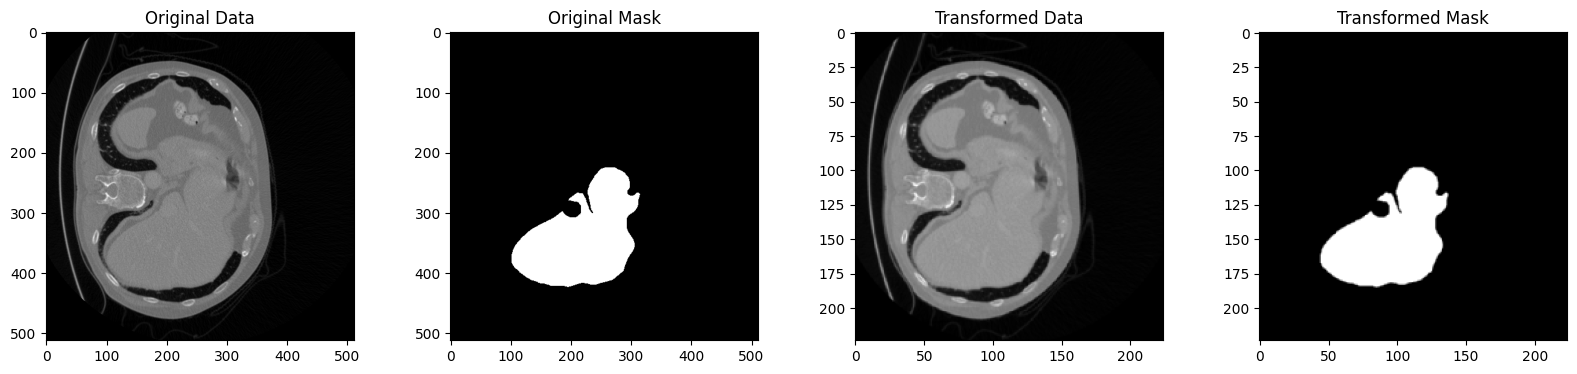

In [11]:
############### change here #################
spatial_size = [224, 224]
############### change here #################

resizer = Resized(keys=['image', 'mask'], spatial_size=spatial_size)
resized_data = resizer(data)

show_transform_result(data, resized_data, with_mask=True)

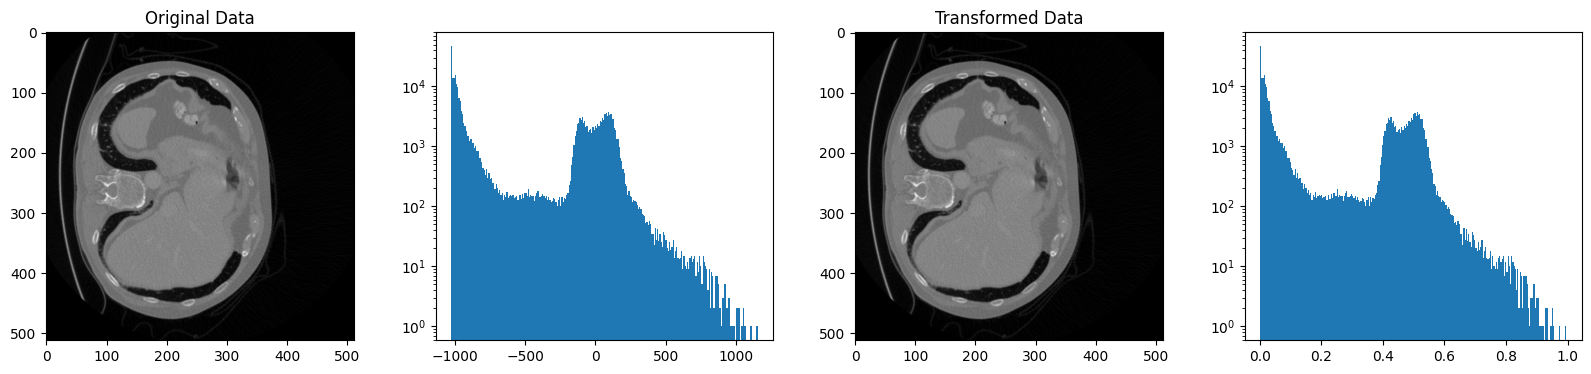

In [13]:
normalizer = ScaleIntensityd(keys='image', minv=0.0, maxv=1.0)
normalized_data = normalizer(data)

show_transform_result(data, normalized_data, with_histogram=True)

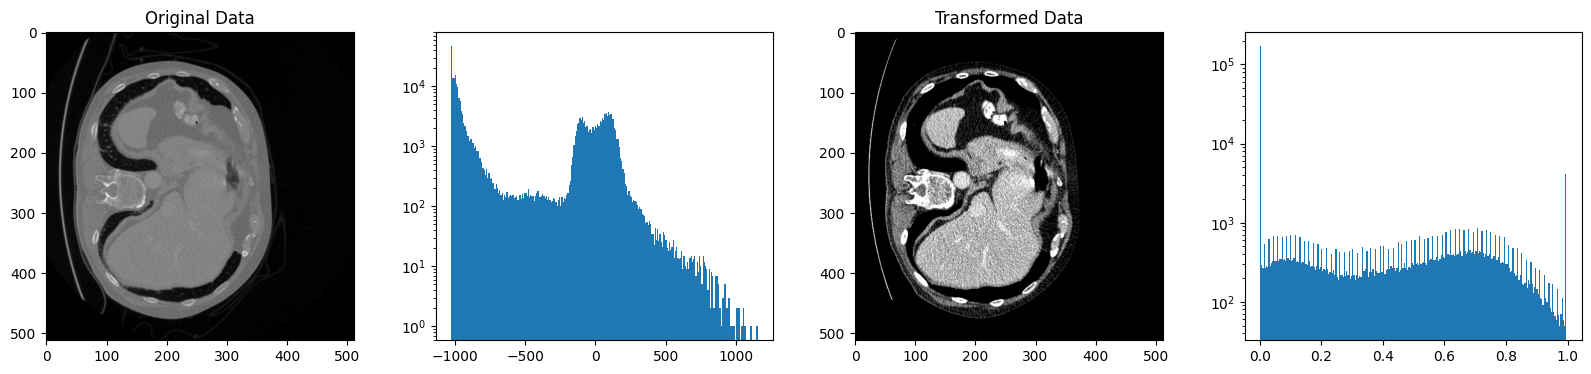

In [17]:
############### change here #################
window_min = -125
window_max = 200
############### change here #################

windower = ScaleIntensityRanged(
    keys=['image'],
    a_min=window_min,
    a_max=window_max,
    b_min=0,
    b_max=1,
    clip=True
)
windowed_data = windower(data)
show_transform_result(data, windowed_data, with_histogram=True)

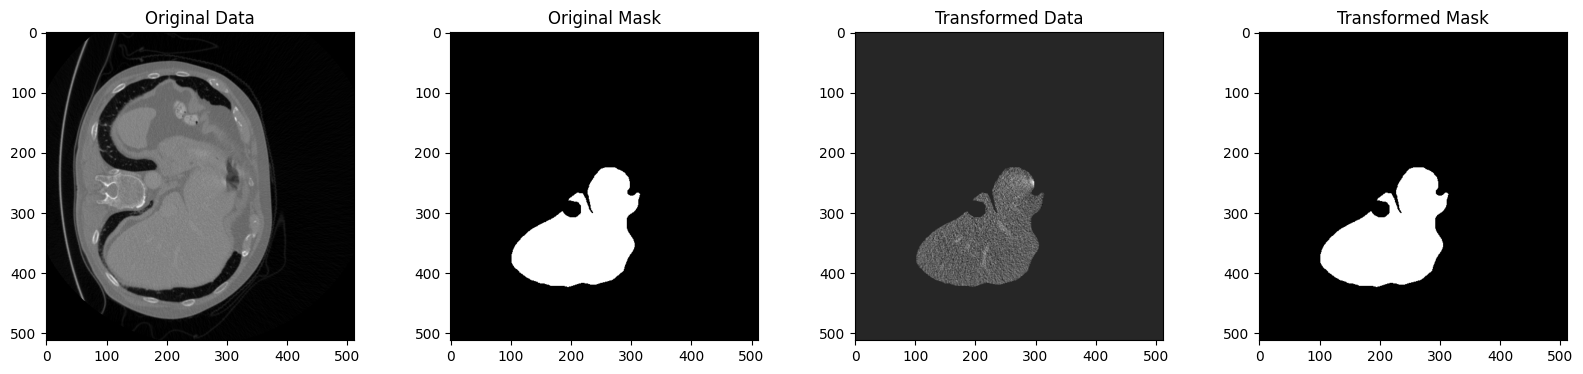

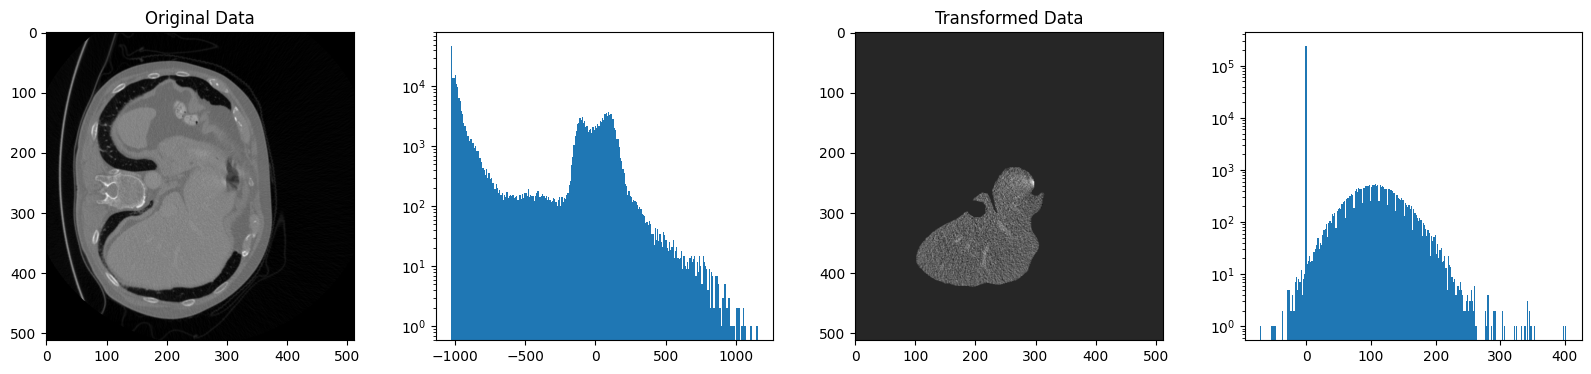

In [18]:
masker = MaskIntensityd(keys='image', mask_key='mask')
masked_data = masker(data)

show_transform_result(data, masked_data, with_mask=True)
show_transform_result(data, masked_data, with_histogram=True)

### 3-3. 資料增強
我們可以執行資料增強來增加資料的多樣性. \

*   **旋轉**
*   **裁減**
*   **平移**
*   **放大縮小**
*   **翻轉**

 [其他](https://docs.monai.io/en/stable/transforms.html#).

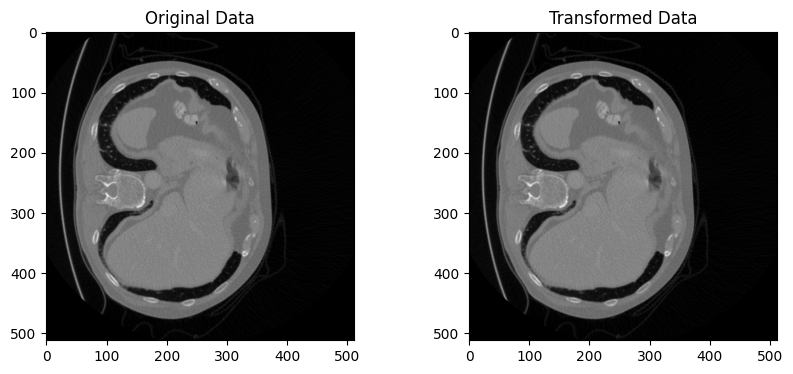

In [19]:
############### change here #################
rotate_range = [[0, 0]] # in radian, e.g., [np.pi/4, np.pi/2]
shear_range = [[0, 0], [0, 0]] # in ratio e.g., [0, 1]
translate_range = [[0, 0], [0, 0]] # in number of pixel, e.g., [0, 128]
scale_range = [[0, 0], [0, 0]] # in ratio e.g., [0, 1]
prob = 1.0
############### change here #################

affine = RandAffined(
    keys='image',
    rotate_range=rotate_range,
    shear_range=shear_range,
    translate_range=translate_range,
    scale_range=scale_range,
    prob=prob,
    padding_mode='border'
)
affine_data = affine(data)

show_transform_result(data, affine_data)

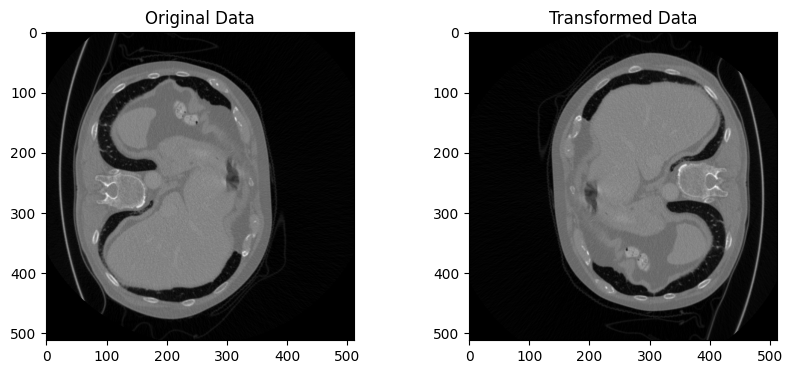

In [31]:
############### change here #################
spatial_axis = [0, 1]
prob = 0.5
############### change here #################

flipper = RandFlipd(keys='image', spatial_axis=spatial_axis, prob=prob)
flipped_data = flipper(data)

show_transform_result(data, flipped_data)

### 3-4. 資料前處理設定
在此設定資料前處理的超參數。並沒有所謂的“最佳”值。可以透過反覆的嘗試找規律。

In [35]:
# Load data and perform image processing
load = [
    LoadImaged(keys=['image', 'mask'], ensure_channel_first=True),
    Resized(keys=['image', 'mask'], spatial_size=[224, 224]),
    EnsureTyped(keys=['image', 'label']),
    ToDeviced(keys=['image', 'label'], device='cuda')
]

############### change here #################
preprocess = [
    Resized(keys='image',spatial_size=[224,224]),
    ScaleIntensityRanged(
        keys=['image'],
        a_min=-125,
        a_max=200,
        b_min=0,
        b_max=1,
        clip=True
    ),
    MaskIntensityd(keys='image', mask_key='mask'),
    RepeatChanneld(keys='image', repeats=3),
]
augmentation = [
    RandAffined(
        keys='image',
        rotate_range=[[np.pi/18, np.pi/9]],
        shear_range=[[0, 0], [0, 0]],
        translate_range=[[30, 60], [0, 0]],
        scale_range=[[0, 0], [0, 0]],
        prob=1.0,
        padding_mode='border'
    )
]

############### change here #################
cache_rate = 1

train_transform = Compose(load+preprocess+augmentation)
valid_transform = Compose(load+preprocess)
test_transform = Compose(load+preprocess)

train_set = CacheDataset(train_list, train_transform, cache_rate=cache_rate)
valid_set = CacheDataset(valid_list, valid_transform, cache_rate=cache_rate)
test_set = CacheDataset(test_list, test_transform, cache_rate=cache_rate)

Loading dataset: 100%|██████████| 752/752 [00:18<00:00, 41.16it/s]


在載入資料之後，我們來看一下資料分布。

In [36]:
# check label distribution
def check_dist(dataset):
    positive = 0
    negative = 0
    for data in dataset:
        if data['label'].item() == 1:
            positive += 1
        else:
            negative += 1
    print(
        f'number of positive = {positive:.0f}, '
        f'number of negative = {negative:.0f}, '
        f'number of total data = {len(dataset)}'
    )

check_dist(train_set)
check_dist(valid_set)
check_dist(test_set)

number of positive = 798, number of negative = 1443, number of total data = 2241
number of positive = 214, number of negative = 506, number of total data = 720
number of positive = 282, number of negative = 470, number of total data = 752


我們來看一些`訓練集`裡的影像。你也可以挑一些驗證集裡的影像出來看。

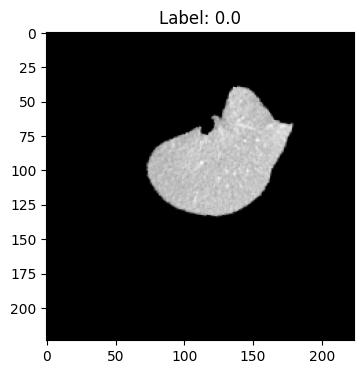

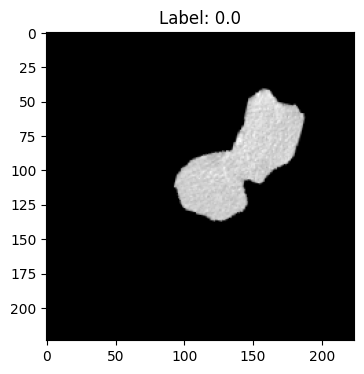

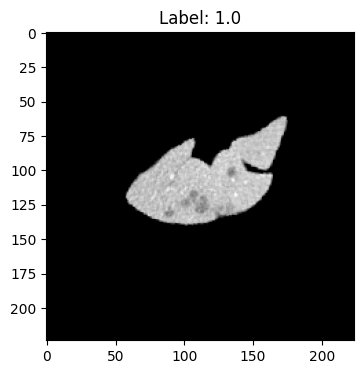

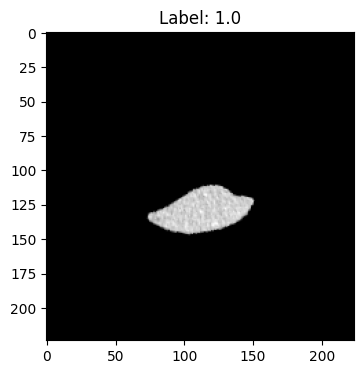

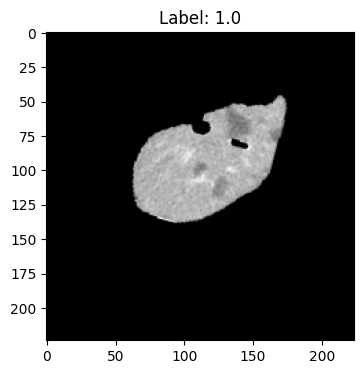

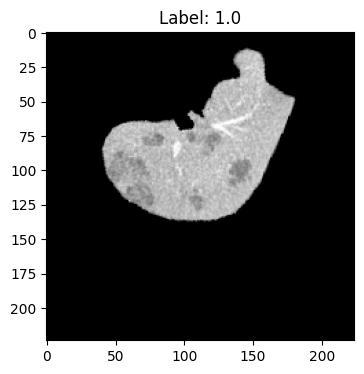

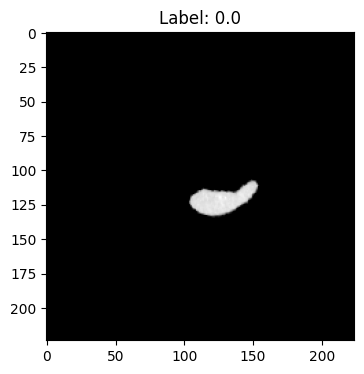

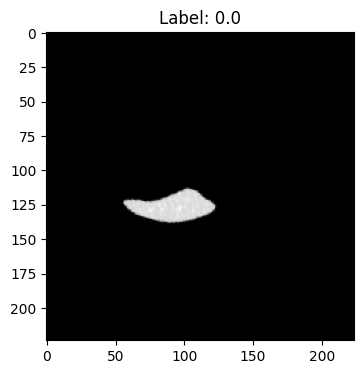

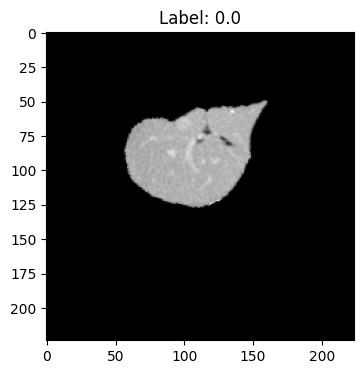

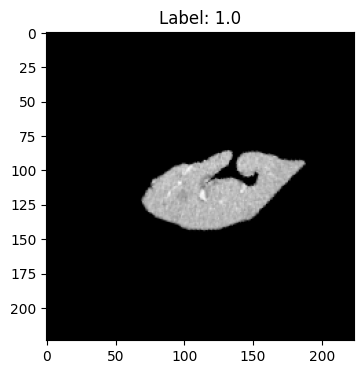

In [49]:
random_index = np.random.randint(0, len(train_set), 10)
for index in random_index:
    data = train_set[index]
    show_data(data, to_cpu=True)

## 4\. 建立模型
準備好資料之後，我們來建立一個CNN模型來判斷拍CT影像的病人是否有肝癌。 \
這裡我們使用 Pytorch 的 MobileNet 因為它跑的速度很快。 \
你也可以嘗試使用不同的 [模型](https://pytorch.org/vision/stable/models.html#classification)。 大部分模型的權重都是用 [ImageNet](https://www.image-net.org/) 訓練出的結果。

補充：MobileNet接受的是 (3, 224, 224) 大小的影像, 因此我們在做前處理時把調整大小的參數設定成 `spatial_size=[224, 224]`，(3, 224, 224) 裡面的 '3' 代表的是RGB影像裡的通道數：紅，綠，藍。

### 4-1. 下載訓練好的模型權重，設超参數

In [55]:
############### change here #################
# Set the model
model = timm.create_model('resnet18', pretrained=True, num_classes=1)

# Set the hyperparameters
num_epoch = 20
batch_size = 128
lr = 1e-5
############### change here #################

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4-2. 訓練模型
在這裡開始訓練模型， \
這可能會跑一段時間。


In [56]:
record = {'train': [], 'valid': []}
best_valid_loss = np.inf
for epoch in tqdm(range(num_epoch)):
    train_loss = 0.0
    valid_loss = 0.0
    # training
    model.train()
    for data in train_loader:
        images = data['image'].to(device)
        labels = data['label'].to(device)

        optimizer.zero_grad() # zero out the optimizer gradient
        preds = model(images) # model prediction
        loss = criterion(preds, labels) # calculate loss
        loss.backward() # calculate gradient of loss w.r.t. model weights
        optimizer.step() # weights update
        train_loss += loss.item()

    # validation
    model.eval()
    with torch.no_grad():
        for data in valid_loader:
            images = data['image'].to(device)
            labels = data['label'].to(device)

            preds = model(images)
            loss = criterion(preds, labels)
            valid_loss += loss.item()


    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    # save model with lowest validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_state = model.state_dict().copy()

    record['train'].append(train_loss)
    record['valid'].append(valid_loss)

    print(
        f'[{epoch+1}/{num_epoch}] '
        f'Train loss: {train_loss:3.3f}, '
        f'Valid loss: {valid_loss:3.3f} '
    )


  0%|          | 0/20 [00:00<?, ?it/s]

[1/20] Train loss: 0.695, Valid loss: 0.731 
[2/20] Train loss: 0.686, Valid loss: 0.708 
[3/20] Train loss: 0.679, Valid loss: 0.699 
[4/20] Train loss: 0.672, Valid loss: 0.694 
[5/20] Train loss: 0.663, Valid loss: 0.667 
[6/20] Train loss: 0.656, Valid loss: 0.649 
[7/20] Train loss: 0.648, Valid loss: 0.641 
[8/20] Train loss: 0.640, Valid loss: 0.633 
[9/20] Train loss: 0.632, Valid loss: 0.626 
[10/20] Train loss: 0.626, Valid loss: 0.617 
[11/20] Train loss: 0.619, Valid loss: 0.610 
[12/20] Train loss: 0.612, Valid loss: 0.602 
[13/20] Train loss: 0.605, Valid loss: 0.595 
[14/20] Train loss: 0.599, Valid loss: 0.591 
[15/20] Train loss: 0.594, Valid loss: 0.585 
[16/20] Train loss: 0.589, Valid loss: 0.580 
[17/20] Train loss: 0.585, Valid loss: 0.576 
[18/20] Train loss: 0.581, Valid loss: 0.572 
[19/20] Train loss: 0.579, Valid loss: 0.568 
[20/20] Train loss: 0.577, Valid loss: 0.565 


在訓練完模型之後，我們可以觀察loss值在訓練集和驗證集上的表現。

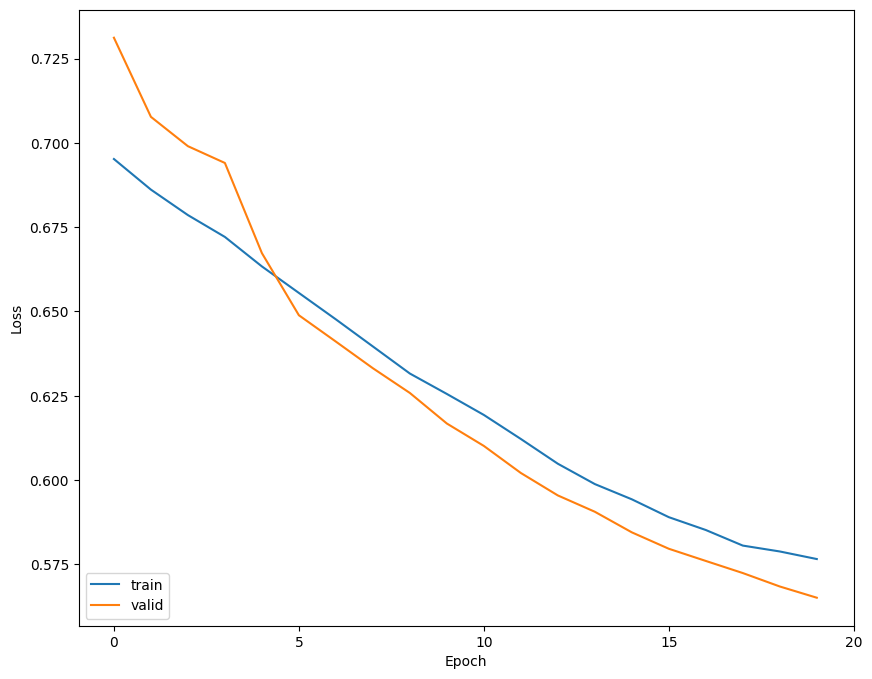

In [57]:
# plot loss
fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.plot(record['train'])
axs.plot(record['valid'])
axs.set_xticks(range(0, num_epoch+1, 5))
axs.set_ylabel('Loss')
axs.set_xlabel('Epoch')
axs.legend(['train', 'valid'], loc='lower left')
plt.show()

## 5\. 檢視成果
訓練完模型之後，我們來看一下訓練的成果。
看分類結果。
把模型輸出值變成0跟1，跟標準答案比較，產出混淆矩陣的值，靈敏度，特異度。

In [58]:
# helper function for inference and plotting
def infer(model, data_loader):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    sigmoid = torch.nn.Sigmoid()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            images = data['image'].to(device)
            labels = data['label'].to(device)

            preds = sigmoid(model(images))

            for pred, label in zip(preds, labels):
                y_pred.append(pred.item())
                y_true.append(label.item())

    return y_true, y_pred

def plot_result(y_true, y_pred, thres=0.5, title=''):
    # plot the ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5, 4))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    plt.show()

    # binarize the predictions
    y_pred = np.where(np.array(y_pred)>=thres, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(
        f'True positive: {tp}\n'
        f'False positive: {fp}\n'
        f'False negative: {fn}\n'
        f'True negative: {tn}\n'
        f'Sensitivity: {sensitivity:.4f}\n'
        f'Specificity: {specificity:.4f}'
    )

In [59]:
# load the best weight and infer
model.load_state_dict(best_state)
train_true, train_pred = infer(model, train_loader)
valid_true, valid_pred = infer(model, valid_loader)
test_true, test_pred = infer(model, test_loader)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

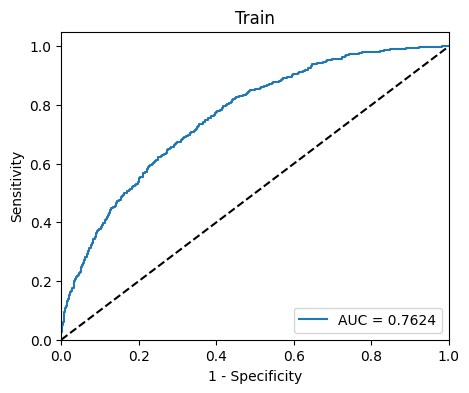

True positive: 224
False positive: 91
False negative: 574
True negative: 1352
Sensitivity: 0.2807
Specificity: 0.9369




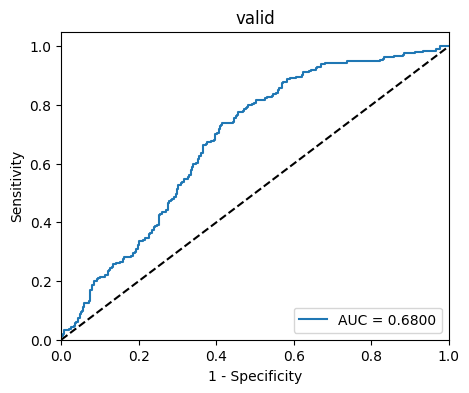

True positive: 9
False positive: 13
False negative: 205
True negative: 493
Sensitivity: 0.0421
Specificity: 0.9743




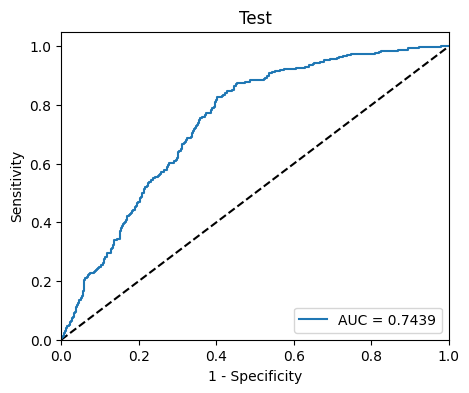

True positive: 47
False positive: 27
False negative: 235
True negative: 443
Sensitivity: 0.1667
Specificity: 0.9426


In [60]:
############### change here #################
thres = 0.5
############### change here #################

plot_result(train_true, train_pred, thres=thres, title='Train')
print('\n')
plot_result(valid_true, valid_pred, thres=thres, title='valid')
print('\n')
plot_result(test_true, test_pred, thres=thres, title='Test')